# Main Notebook for Leakage Detection

## Setup

### Google Colab Setup

In [6]:
# Mount Google Colab files

from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection


### Imports

In [7]:
!pip install wntr
!pip install scipy
!pip install tqdm
%matplotlib inline

import wntr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from collections import Counter

In [52]:
import utils
import models

from utils.Network import WDN
from utils.Dataloader import Dataloader
from utils.Datagenerator import Datagenerator
from models.Classification import ClassificationModel

from utils.helper import any_transform
from utils.helper import shuffle_data
from utils.metrics import print_metrics

import importlib
importlib.reload(utils.helper)
importlib.reload(utils.metrics)
importlib.reload(utils.Network)
importlib.reload(utils.Dataloader)
importlib.reload(utils.Datagenerator)
importlib.reload(models.Classification)

<module 'models.Classification' from '/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection/models/Classification.py'>

### Plotting

In [9]:
def plot(df, xlabel="Time (h)", ylabel="Pressure (m)", location="upper right", line_at=[], highlight_first=False):
  plt.figure()
  ax = df.plot()
  if highlight_first:
    plt.setp(ax.lines[0], linewidth=3)
  text = ax.set_xlabel(xlabel)
  text = ax.set_ylabel(ylabel)
  for line in line_at:
    plt.axvline(x=line, color='k', linestyle='--')
  plt.legend(loc = location)
  plt.show()

def show_data(X, y):
  # Get Leakage time
  first_leakage_at = np.argmax(y)
  print('Leakage at', first_leakage_at, 'Day', first_leakage_at // 24, 'Hour', first_leakage_at % 24)

  # Plot window around leakage time
  plot(X.loc[first_leakage_at-3*24:first_leakage_at+3*24, X.columns != 'hour of the day'], line_at=[first_leakage_at], location="lower left")

  # Plot whole data including y
  Xy = X.copy()
  Xy['y'] = y * (96 - 71) + 71
  plot(Xy.loc[:, Xy.columns != 'hour of the day'], location="lower left")

## Main

### Data Generation

Nodes: ['10', '11', '12', '13', '2', '21', '22', '23', '31', '32', '9']
->Important: ['10', '11', '12', '13', '21', '22', '23', '31', '32']
Edges: [('10', '11'), ('11', '12'), ('11', '21'), ('12', '13'), ('12', '22'), ('13', '23'), ('21', '22'), ('21', '31'), ('22', '23'), ('22', '32'), ('31', '32'), ('9', '10'), ('2', '12')]


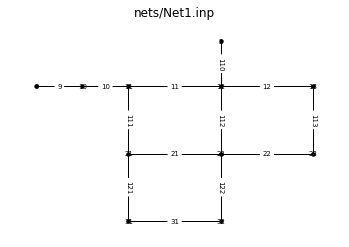

In [10]:
wdn = WDN("nets/Net1.inp", ['10', '11','12','13','21','22','23','31','32'])
wdn.show()
gen = Datagenerator(wdn)

In [17]:
X, y = gen.gen_dataset(size=50*6, shuffle=True)

Generating 150 leakage scenarios...


100%|██████████| 150/150 [02:59<00:00,  1.20s/it]


Generating 150 non leakage scenarios...


100%|██████████| 150/150 [03:04<00:00,  1.23s/it]


### Testing

In [ ]:
from sklearn.model_selection import GridSearchCV
from utils.metrics import accuracy, recall, specificity, precision, detection_time
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsClassifier

scoring = {'accuracy': make_scorer(accuracy),
           'recall': make_scorer(recall),
           'specificity': make_scorer(specificity),
           'precision': make_scorer(precision),
           'detection_time': make_scorer(detection_time)}

parameters = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}

model = ClassificationModel(KNeighborsClassifier())

grid = GridSearchCV(model, parameters, scoring=scoring, refit='detection_time')

grid.fit(X, y)

print(grid.best_params_)
pd.DataFrame(grid.cv_results_)

{'n_neighbors': 9, 'weights': 'uniform'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,...,std_test_precision,rank_test_precision,split0_test_detection_time,split1_test_detection_time,split2_test_detection_time,split3_test_detection_time,split4_test_detection_time,mean_test_detection_time,std_test_detection_time,rank_test_detection_time
0,0.094885,0.003757,1.169344,0.032192,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",1.0,1.0,1.0,...,0.0,1,1.250000,1.169811,1.096774,1.190476,1.155172,1.172447,0.049742,7
1,0.091561,0.000598,0.742765,0.006962,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",1.0,1.0,1.0,...,0.0,1,1.250000,1.169811,1.096774,1.190476,1.137931,1.168999,0.051390,8
2,0.095137,0.003069,1.183111,0.011862,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",1.0,1.0,1.0,...,0.0,1,1.250000,1.226415,1.193548,1.253968,1.172414,1.219269,0.031801,5
3,0.095661,0.003544,0.786107,0.002913,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",1.0,1.0,1.0,...,0.0,1,1.250000,1.226415,1.193548,1.253968,1.172414,1.219269,0.031801,5
4,0.092328,0.001769,1.215321,0.011782,7,uniform,"{'n_neighbors': 7, 'weights': 'uniform'}",1.0,1.0,1.0,...,0.0,1,1.359375,1.226415,1.258065,1.396825,1.224138,1.292964,0.071528,3
5,0.093317,0.002684,0.820099,0.007929,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",1.0,1.0,1.0,...,0.0,1,1.359375,1.226415,1.241935,1.396825,1.206897,1.286290,0.076701,4
6,0.092418,0.000653,1.249859,0.029329,9,uniform,"{'n_neighbors': 9, 'weights': 'uniform'}",1.0,1.0,1.0,...,0.0,1,1.484375,1.339623,1.338710,1.396825,1.344828,1.380872,0.056117,1
7,0.092874,0.002326,0.842731,0.015471,9,distance,"{'n_neighbors': 9, 'weights': 'distance'}",1.0,1.0,1.0,...,0.0,1,1.453125,1.245283,1.322581,1.396825,1.344828,1.352528,0.070057,2


### Der Train-Test-Split

Mit dem Train-Test-Split können wir 'overfitting' bei der Evaluation verhindern.

In [ ]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# Check the distribution of leak/ no leak cases for the split
y_train_any, y_test_any = any_transform(y_train, y_test)
print(Counter(y_train_any))
print(Counter(y_test_any))

Counter({0: 227, 1: 223})
Counter({1: 77, 0: 73})


Nun können wir den ersten Classifier, SVM, testen.

In [ ]:
from sklearn.svm import SVC

# Create the model
model = ClassificationModel(SVC(gamma=0.001), medfilt_kernel_size=5)

# Learn on the train subset
model.fit(X_train, y_train)

# Predict on the test subset
y_pred = model.predict(X_test)

Leakage at 101 Day 4 Hour 5


<Figure size 432x288 with 0 Axes>

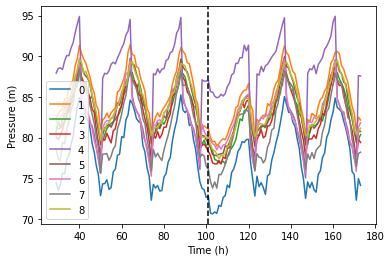

<Figure size 432x288 with 0 Axes>

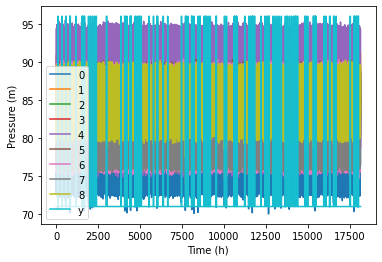

[[73  0]
 [ 1 76]]
Accuracy:     0.993	Wie oft lag der Algorithmus richtig?
Recall (Sns): 0.987	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?
Precision:    1.0	Wie viele erkannte lecks waren auch wirklich Lecks?
Mean Detection Time: 8.132h	Wie viele Stunden dauerte es bis zum erkennen?


In [ ]:
# Display the pressure values
X_show = pd.DataFrame(X_test.reshape((X_test.shape[0]*X_test.shape[1], X_test.shape[2])))
y_pred_show = np.concatenate(y_pred)
y_true_show = np.concatenate(y_test)

show_data(X_show.loc[:, X_show.columns != 9], y_pred_show)

# Show metric results
print_metrics(y_test, y_pred)

Confusion Matrix:
```
[[TN  FP]
 [FN  TP]]
```


Testen wir jetzt verschiedene Modelle aus.

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from utils.metrics import accuracy, recall, specificity, precision, detection_time
from tqdm import tqdm

metrics = [accuracy, recall, specificity, precision, detection_time]
base_models = [SVC(gamma=0.001),
               KNeighborsClassifier(n_neighbors=5),
               MLPClassifier(hidden_layer_sizes=(18,10))]
results = {}

for base_model in tqdm(base_models):
  model = ClassificationModel(base_model, medfilt_kernel_size=5)
  y_pred = model.fit(X_train, y_train).predict(X_test)
  results[base_model] = [round(metric(y_test, y_pred), 3) for metric in metrics]

results = pd.DataFrame(results).T
results.columns = 'accuracy', 'recall', 'specificity', 'precision', 'detection_time'
results

100%|██████████| 3/3 [01:03<00:00, 21.31s/it]


,accuracy,recall,specificity,precision,detection_time
SVC(gamma=0.001),0.993,0.987,1.000,1.000,8.132
KNeighborsClassifier(),1.000,1.000,1.000,1.000,1.130
"MLPClassifier(hidden_layer_sizes=(18, 10))",0.980,1.000,0.959,0.962,6.130


### Das Cross-Validation

Beim einfachen Test-Train-Split kann es passieren, dass die Auswahl des Splits zu einem ungenauen Ergebnis führt. Um dort entgegen zu wirken, nutzt man Kreuzvalidierung, welche den Split einfach k mal neu wiederholt. Der Mittelwert der Ergebnisse ist dann ein weitaus sichereres Ergebnis. 

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from utils.metrics import accuracy, recall, specificity, precision, detection_time
from sklearn.metrics import make_scorer

scoring = {'accuracy': make_scorer(accuracy),
           'recall': make_scorer(recall),
           'specificity': make_scorer(specificity),
           'precision': make_scorer(precision),
           'detection_time': make_scorer(detection_time)}

model = ClassificationModel(KNeighborsClassifier(n_neighbors=3), medfilt_kernel_size=5)

cv_results = cross_validate(model, X, y, cv=10, scoring=scoring)
pd.DataFrame(cv_results)

,fit_time,score_time,test_accuracy,test_recall,test_specificity,test_precision,test_detection_time
0,0.116389,0.669118,1.0,1.0,1.0,1.0,1.272727
1,0.115368,0.627223,1.0,1.0,1.0,1.0,1.193548
2,0.111802,0.644287,1.0,1.0,1.0,1.0,1.160000
3,0.112915,0.644998,1.0,1.0,1.0,1.0,1.178571
4,0.110137,0.624134,1.0,1.0,1.0,1.0,1.125000
5,0.112773,0.651486,1.0,1.0,1.0,1.0,1.033333
6,0.121822,0.610934,1.0,1.0,1.0,1.0,1.258065
7,0.111886,0.643030,1.0,1.0,1.0,1.0,1.125000
8,0.112761,0.636141,1.0,1.0,1.0,1.0,1.171429
9,0.114029,0.664640,1.0,1.0,1.0,1.0,1.043478


### Das Grid-Search

Um nun verschiedene Hyperparameter für einen Algorithmus zu testen, nutzen wir Grid-Search, welches alle möglichen Kombinationen von ausgewählten Parametern mittels Cross-Validation testet

In [53]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from utils.metrics import accuracy, recall, specificity, precision, detection_time
from sklearn.metrics import make_scorer

scoring = {'accuracy': make_scorer(accuracy),
           'recall': make_scorer(recall),
           'specificity': make_scorer(specificity),
           'precision': make_scorer(precision),
           'detection_time': make_scorer(detection_time)}

important_results = ['mean_test_accuracy', 'mean_test_detection_time',
                     'mean_test_precision', 'mean_test_recall',
                     'mean_test_specificity']

Für KNN testen wir verschiedene Gewichte und die Anzahl der betrachteten Nachbarn.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

parameters_knn = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
model_knn = ClassificationModel(KNeighborsClassifier())

grid = GridSearchCV(model_knn, parameters_knn, scoring=scoring, refit='detection_time', cv=4, verbose=3)
grid.fit(X, y)

In [73]:
print(grid.best_params_)
results_knn = pd.DataFrame(grid.cv_results_)

results_knn[['param_n_neighbors', 'param_weights'] + important_results].sort_values('mean_test_detection_time', ascending=False)

{'n_neighbors': 3, 'weights': 'uniform'}


,param_n_neighbors,param_weights,mean_test_accuracy,mean_test_detection_time,mean_test_precision,mean_test_recall,mean_test_specificity
0,3,uniform,1.0,-1.449089,1.0,1.0,1.0
1,3,distance,1.0,-1.449089,1.0,1.0,1.0
2,5,uniform,1.0,-1.514879,1.0,1.0,1.0
3,5,distance,1.0,-1.514879,1.0,1.0,1.0
4,7,uniform,1.0,-1.715635,1.0,1.0,1.0
5,7,distance,1.0,-1.715635,1.0,1.0,1.0
6,9,uniform,1.0,-1.829791,1.0,1.0,1.0
7,9,distance,1.0,-1.829791,1.0,1.0,1.0


Für SVM testen wir verschiedene Kernels, Regularization-Parameter C und Gamma.

In [74]:
from sklearn.svm import SVC

parameters_svm = {'kernel': ['linear', 'poly', 'rbf'], 
                  'C': [10**e for e in range(-1, 2)], 
                  'gamma': [0.001, 0.003]}
model_svm = ClassificationModel(SVC())

grid = GridSearchCV(model_svm, parameters_svm, scoring=scoring, refit='detection_time', cv=4, verbose=3)
grid.fit(X, y)

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END C=0.1, gamma=0.001, kernel=linear; accuracy: (test=0.973) detection_time: (test=-11.500) precision: (test=1.000) recall: (test=0.947) specificity: (test=1.000) total time=  27.8s
[CV 2/4] END C=0.1, gamma=0.001, kernel=linear; accuracy: (test=1.000) detection_time: (test=-10.686) precision: (test=1.000) recall: (test=1.000) specificity: (test=1.000) total time=  26.8s
[CV 3/4] END C=0.1, gamma=0.001, kernel=linear; accuracy: (test=0.973) detection_time: (test=-9.778) precision: (test=1.000) recall: (test=0.947) specificity: (test=1.000) total time=  25.3s
[CV 4/4] END C=0.1, gamma=0.001, kernel=linear; accuracy: (test=0.987) detection_time: (test=-11.737) precision: (test=1.000) recall: (test=0.974) specificity: (test=1.000) total time=  24.5s
[CV 1/4] END C=0.1, gamma=0.001, kernel=poly; accuracy: (test=1.000) detection_time: (test=-9.158) precision: (test=1.000) recall: (test=1.000) specificity: (test=1.000) to

GridSearchCV(cv=4,
             estimator=ClassificationModel(C=1.0, break_ties=False,
                                           cache_size=200, class_weight=None,
                                           coef0=0.0,
                                           decision_function_shape='ovr',
                                           degree=3, gamma='scale',
                                           kernel='rbf', max_iter=-1,
                                           model=SVC(), probability=False,
                                           random_state=None, shrinking=True,
                                           tol=0.001, verbose=False),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.001, 0.003],
                         'kernel': ['linear', 'poly', 'rbf']},
             refit='detection_time',
             scoring={'accuracy': make_scorer(accuracy),
                      'detection_time': make_scorer(detection_time),
                      'precision': make_scorer(prec

In [75]:
print(grid.best_params_)
results_svm = pd.DataFrame(grid.cv_results_)

results_svm[['param_C', 'param_gamma', 'param_kernel'] + important_results][results_svm['param_kernel'] != 'sigmoid'].sort_values('mean_test_detection_time', ascending=False)

{'C': 10, 'gamma': 0.003, 'kernel': 'rbf'}


,param_C,param_gamma,param_kernel,mean_test_accuracy,mean_test_detection_time,mean_test_precision,mean_test_recall,mean_test_specificity
17,10,0.003,rbf,1.000000,-4.104429,1.0,1.000000,1.0
11,1,0.003,rbf,1.000000,-6.533791,1.0,1.000000,1.0
14,10,0.001,rbf,1.000000,-7.010194,1.0,1.000000,1.0
5,0.1,0.003,rbf,0.996667,-8.284774,1.0,0.993590,1.0
8,1,0.001,rbf,0.996667,-8.412594,1.0,0.993590,1.0
13,10,0.001,poly,0.996667,-8.564662,1.0,0.993590,1.0
16,10,0.003,poly,0.996667,-8.823120,1.0,0.993590,1.0
10,1,0.003,poly,0.996667,-8.952068,1.0,0.993590,1.0
4,0.1,0.003,poly,0.996667,-8.957331,1.0,0.993590,1.0
7,1,0.001,poly,0.996667,-9.691353,1.0,0.993590,1.0


Für MLP, also künstliche Neurale Netze, ist die Anzahl und Form der versteckten Layers mit entscheidend. Da hier nicht alle möglichen Kombinationen ausgetestet werden können, nutzen wir RandomizedSearchCV, welche keine erschöpfende Suche durch alle möglichen Parameterkombinationen, sondern nur eine zufällige Suche macht. Zwar wird hierdurch nicht das Optimum gefunden, aber wenigstens wird ein gutes gefunden (Runtime vs. Quality Tradeoff). Hierfür wird eine neue Klasse gebraucht, welche randomisierte Hidden-Layer-Shapes generiert.

In [70]:
class NNSize(object):
    def __init__(self, shape_min=1, shape_max=3, size_min=5, size_max=24):
        self.shape_min = shape_min
        self.shape_max = shape_max
        self.size_min = size_min
        self.size_max = size_max

    def rvs(self, random_state=None):
        #np.random.seed(random_state)
        shape = np.random.randint(self.shape_min, self.shape_max+1)
        return tuple([np.random.randint(self.size_min, self.size_max+1) for _ in range(shape)])

In [ ]:
from sklearn.neural_network import MLPClassifier

parameters_mlp = {'hidden_layer_sizes': NNSize(), 
                  'learning_rate': ['constant', 'adaptive'], 
                  'activation': ['logistic', 'tanh', 'relu']}
model_mlp = ClassificationModel(MLPClassifier())

grid = RandomizedSearchCV(model_mlp, parameters_mlp, scoring=scoring, refit='detection_time', cv=4, verbose=3, n_iter=30)
grid.fit(X, y)

In [69]:
print(grid.best_params_)
results_mlp = pd.DataFrame(grid.cv_results_)

results_mlp[['param_learning_rate', 'param_activation', 'param_hidden_layer_sizes'] + important_results].sort_values('mean_test_detection_time', ascending=False)

{'activation': 'logistic', 'hidden_layer_sizes': (23, 13), 'learning_rate': 'adaptive'}


,param_learning_rate,param_activation,param_hidden_layer_sizes,mean_test_accuracy,mean_test_detection_time,mean_test_precision,mean_test_recall,mean_test_specificity
7,adaptive,logistic,"(23, 13)",1.000000,-7.441628,1.000000,1.000000,1.000000
25,constant,tanh,"(17,)",0.956667,-7.538756,0.936275,1.000000,0.912162
8,constant,logistic,"(17, 22)",1.000000,-8.315018,1.000000,1.000000,1.000000
5,adaptive,logistic,"(19, 7)",1.000000,-8.331145,1.000000,1.000000,1.000000
4,constant,logistic,"(10, 20)",0.996667,-8.782707,1.000000,0.993590,1.000000
13,adaptive,logistic,"(15, 16)",1.000000,-8.789392,1.000000,1.000000,1.000000
10,constant,logistic,"(13,)",1.000000,-9.238423,1.000000,1.000000,1.000000
0,constant,tanh,"(18,)",0.996667,-9.285526,1.000000,0.993590,1.000000
1,constant,relu,"(9, 15, 23)",0.980000,-9.399566,0.982143,0.980263,0.979167
2,adaptive,logistic,"(22, 24)",1.000000,-9.717597,1.000000,1.000000,1.000000
